In [1]:
import os
import tqdm
from transformers import AutoTokenizer, AutoModel
import torch
import pickle
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
def load_pickle(filepath):
    with open(filepath, "rb") as fp:
        return pickle.load(fp)


def save_pickle(filepath, object):
    with open(filepath, "wb") as fp:
        pickle.dump(object, fp)

In [3]:
bodyCollection = load_pickle("../data/body_collection.pkl")

In [4]:
len(bodyCollection)

48549

In [7]:
_body_collection = bodyCollection[:200]

In [8]:
class SentenceEmbedding:
    def __init__(self,
                 max_len=128,
                 batch_size=4,
                 model_path="sentence-transformers/bert-base-nli-mean-tokens"):
        MODEL = model_path
        self.model = AutoModel.from_pretrained(MODEL)
        self.tokenizer = AutoTokenizer.from_pretrained(MODEL)
        self.batch_size = batch_size
        self.max_len = max_len
        self.flatten_list = lambda lst: [
            item for sublist in lst for item in sublist
        ]

    def make_batch(self, data):
        batches = []
        for ix in tqdm.trange(0, len(data), self.batch_size):
            if ix + self.batch_size > len(data) - 1:
                batch = data[ix:]
            else:
                batch = [data[_] for _ in range(ix, ix + self.batch_size)]
            batches.append(batch)
        return batches

    def tokenize(self, batch):
        # tokens = {"input_ids": [], "attention_mask": []}
        # for sentence in batch:
        #     toks = self.tokenizer.encode_plus(
        #         sentence,
        #         max_length = self.max_len,
        #         truncation = True,
        #         padding = "max_length",
        #         return_tensors="pt"
        #     )
        #     tokens['input_ids'].append(toks['input_ids'][0])
        #     tokens['attention_mask'].append(toks['attention_mask'][0])
        tokens = self.tokenizer.batch_encode_plus(batch,
                                                  return_tensors="pt",
                                                  max_length=self.max_len,
                                                  padding=True,
                                                  truncation=True)

        return tokens

    def compute_last_hidden_state(self, batch):
        tokens = self.tokenize(batch)
        # print(tokens)
        outputs = self.model(**tokens)
        return outputs.last_hidden_state, tokens

    def compute_mean_pooled_embs(self, batch):
        last_hidden_state, tokens = self.compute_last_hidden_state(batch)
        attention_mask = tokens['attention_mask']
        mask = attention_mask.unsqueeze(-1).expand(
            last_hidden_state.size()).float()
        masked_embedding = last_hidden_state * mask
        summed = torch.sum(masked_embedding, 1)
        summed_mask = torch.clamp(mask.sum(1), min=1e-9)
        mean_pooled = summed / summed_mask
        return mean_pooled, tokens

    def compute_embeddings(self, data):

        batches = self.make_batch(data)
        token_embeddings = {"embeddings": [], "tokens": []}
        for ix in tqdm.trange(len(batches)):
            mean_pooled, tokens = self.compute_mean_pooled_embs(batches[ix])
            token_embeddings['embeddings'].append(mean_pooled)
            token_embeddings['tokens'].append(tokens)
        return token_embeddings

    def embedding_matrix(self, data):
        token_embeddings = self.compute_embeddings(data)
        embeddings = torch.stack(
            self.flatten_list(token_embeddings['embeddings']))
        return embeddings.detach().numpy()


In [9]:
emb = SentenceEmbedding()

In [10]:
embeddings = emb.embedding_matrix(_body_collection)

100%|██████████| 50/50 [00:43<00:00,  1.15it/s]


In [15]:
type(embeddings)

numpy.ndarray

In [16]:
embeddings.shape

(20, 768)

In [11]:
import umap

In [12]:
# umap_embeddings = umap.UMAP(n_neighbors=2, n_components=2, metric='cosine').fit_transform(mean_pooled)
umap_embs = umap.UMAP(n_neighbors=10, n_components=3,
                      metric='cosine').fit_transform(embeddings)


In [13]:
umap_embs.shape

(200, 3)

In [49]:
import hdbscan

cluster = hdbscan.HDBSCAN(min_cluster_size=4,
                          metric='euclidean',
                          cluster_selection_method='eom').fit(umap_embs)


In [50]:
cluster.labels_

array([ 6,  3, -1,  2,  2,  3,  2,  2, -1, -1,  2,  1,  2,  5,  6, -1, -1,
        6,  1,  2,  4,  2,  6,  2,  2, -1,  1,  4,  2,  3,  2,  4, -1,  1,
       -1,  2,  2,  1,  4, -1,  2,  2,  1,  2, -1,  2,  2,  2,  2,  6,  2,
        2,  2,  2,  1,  4,  5, -1,  2,  5, -1, -1,  6, -1,  2,  2,  1,  2,
       -1,  2,  6,  2,  4,  2,  2,  4,  2,  2,  2,  2,  2,  6,  2,  2,  2,
        6,  1,  2,  5,  2,  1,  2,  2,  2,  2,  2,  4,  4,  2,  2,  2,  1,
       -1,  1,  2, -1, -1,  1, -1,  3,  4, -1, -1,  2,  6,  2,  3,  1,  5,
        2,  4,  2, -1,  2,  2,  0, -1, -1,  4,  6, -1, -1,  2,  1,  2,  2,
        2,  2,  2,  2,  2,  2, -1,  0,  2,  4,  2,  2,  2,  5,  5, -1,  2,
        2,  2,  2,  2,  2,  6,  2,  2,  2,  2,  2,  2, -1,  4, -1, -1,  2,
        2, -1,  2,  2,  5, -1,  4,  2,  2,  2,  2,  0,  0,  2,  2,  2, -1,
       -1,  2,  2,  4, -1,  1,  2,  0,  2, -1,  5,  1,  1])

In [51]:
import matplotlib.pyplot as plt
import pandas as pd

In [52]:
_2dUmap = umap.UMAP(n_neighbors=10,
                    n_components=2,
                    min_dist=0.0,
                    metric='cosine').fit_transform(embeddings)


In [53]:
_2dUmap.shape

(200, 2)

In [54]:
result = pd.DataFrame(_2dUmap, columns=['x', 'y'])

In [55]:
result.head()

,x,y
0,0.048723,6.602735
1,1.078809,6.032845
2,0.627714,6.808942
3,4.516899,6.654786
4,4.584865,5.151066


In [56]:
result['labels'] = cluster.labels_

In [57]:
# fig, ax = plt.subplots(figsize = (20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]

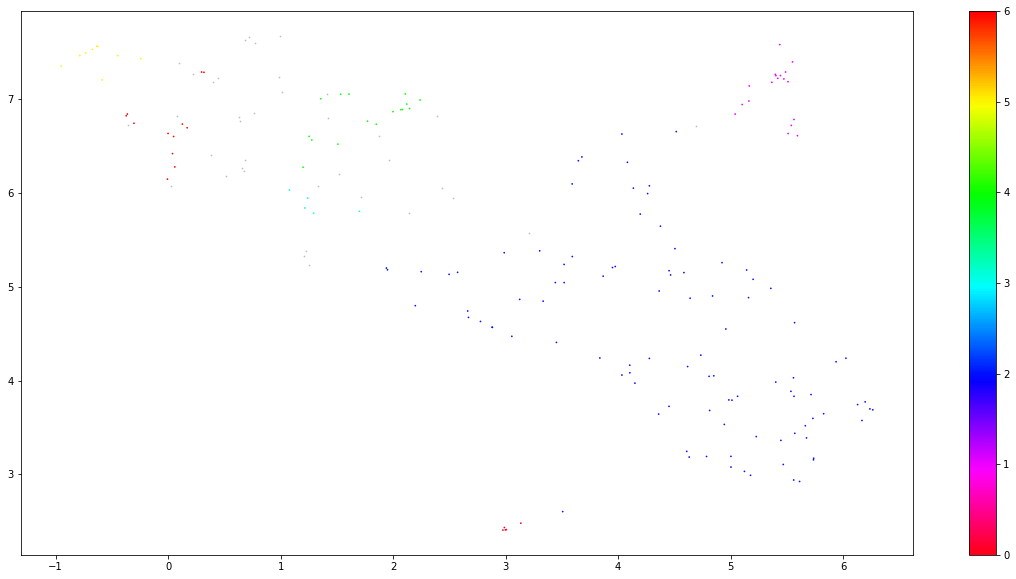

In [58]:
fig, ax = plt.subplots(figsize=(20, 10))
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.5)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.5, cmap='hsv_r')
plt.colorbar()

In [59]:
_body_collection[:2]

['hi since recruiter lead permission approve requisitions makes please make thanks recruiter',
 'icon dear please setup icon per icon engineers please let other details needed thanks lead']

In [60]:
docs_df = pd.DataFrame(_body_collection, columns=["Doc"])
docs_df['Topic'] = cluster.labels_
docs_df['Doc_ID'] = range(len(docs_df))

In [61]:
docs_df.head()

,Doc,Topic,Doc_ID
0,hi since recruiter lead permission approve req...,6,0
1,icon dear please setup icon per icon engineers...,3,1
2,work experience user hi work experience studen...,-1,2
3,requesting meeting hi please help follow equip...,2,3
4,re expire days hi ask help update passwords co...,2,4


In [62]:
docs_per_topic = docs_df.groupby(['Topic'],
                                 as_index=False).agg({'Doc': ' '.join})


In [63]:
type(docs_per_topic)

pandas.core.frame.DataFrame

In [64]:
docs_per_topic.head()

,Topic,Doc
0,-1,work experience user hi work experience studen...
1,0,maternity leaver form hello please fill matern...
2,1,connected rebuild hi please provide order debu...
3,2,requesting meeting hi please help follow equip...
4,3,icon dear please setup icon per icon engineers...


In [65]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer


def c_tf_idf(documents, m, ngram_range=(1, 1)):

    count = CountVectorizer(ngram_range=ngram_range,
                            stop_words="english").fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)
    return tf_idf, count

In [66]:
tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(_body_collection))

In [67]:
tf_idf, count

(array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.01042976, ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.02014569, 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]]),
 CountVectorizer(stop_words='english'))

In [68]:
def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {
        label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1]
        for i, label in enumerate(labels)
    }
    return top_n_words


In [69]:
def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic']).Doc.count().reset_index().rename(
        {
            "Topic": "Topic",
            "Doc": "Size"
        }, axis='columns').sort_values("Size", ascending=False))
    return topic_sizes

In [70]:
top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n = 20)

In [71]:
topic_sizes = extract_topic_sizes(docs_df)

In [72]:
topic_sizes.head(10)

,Topic,Size
3,2,98
0,-1,37
2,1,18
5,4,16
7,6,12
6,5,9
1,0,5
4,3,5


In [73]:
top_n_words[2][:10]

[('friday', 0.013407088898021474),
 ('best', 0.013201243836492998),
 ('information', 0.012569145841895132),
 ('leave', 0.012569145841895132),
 ('annual', 0.011885239721535412),
 ('pm', 0.011462073264812083),
 ('help', 0.011122282747417014),
 ('cards', 0.011101977158247341),
 ('details', 0.010987547328086187),
 ('hi', 0.010740967572076302)]

In [75]:
top_n_words[0][:10]

[('maternity', 0.6992336767430581),
 ('form', 0.3144830133243647),
 ('leaver', 0.26944486556672964),
 ('ca', 0.1972338173209387),
 ('calculator', 0.12321668294297759),
 ('exact', 0.12321668294297759),
 ('cum', 0.12321668294297759),
 ('administration', 0.1070969810694905),
 ('card', 0.10482767110812156),
 ('return', 0.08154785807720888)]

In [76]:
top_n_words[6][:10]

[('reports', 0.0811306879370536),
 ('developer', 0.07033022134600118),
 ('expenditure', 0.06440797462920408),
 ('amended', 0.06440797462920408),
 ('types', 0.06440797462920408),
 ('owners', 0.06440797462920408),
 ('recruiter', 0.06440797462920408),
 ('permanent', 0.05873713395636262),
 ('copy', 0.054713608467526514),
 ('guide', 0.054713608467526514)]

In [74]:
cluster.labels_

array([ 6,  3, -1,  2,  2,  3,  2,  2, -1, -1,  2,  1,  2,  5,  6, -1, -1,
        6,  1,  2,  4,  2,  6,  2,  2, -1,  1,  4,  2,  3,  2,  4, -1,  1,
       -1,  2,  2,  1,  4, -1,  2,  2,  1,  2, -1,  2,  2,  2,  2,  6,  2,
        2,  2,  2,  1,  4,  5, -1,  2,  5, -1, -1,  6, -1,  2,  2,  1,  2,
       -1,  2,  6,  2,  4,  2,  2,  4,  2,  2,  2,  2,  2,  6,  2,  2,  2,
        6,  1,  2,  5,  2,  1,  2,  2,  2,  2,  2,  4,  4,  2,  2,  2,  1,
       -1,  1,  2, -1, -1,  1, -1,  3,  4, -1, -1,  2,  6,  2,  3,  1,  5,
        2,  4,  2, -1,  2,  2,  0, -1, -1,  4,  6, -1, -1,  2,  1,  2,  2,
        2,  2,  2,  2,  2,  2, -1,  0,  2,  4,  2,  2,  2,  5,  5, -1,  2,
        2,  2,  2,  2,  2,  6,  2,  2,  2,  2,  2,  2, -1,  4, -1, -1,  2,
        2, -1,  2,  2,  5, -1,  4,  2,  2,  2,  2,  0,  0,  2,  2,  2, -1,
       -1,  2,  2,  4, -1,  1,  2,  0,  2, -1,  5,  1,  1])

In [ ]:
top_n_wordsa

In [ ]:
# import hdbscan
# cluster = hdbscan.HDBSCAN(min_cluster_size=15,
#                           metric='euclidean',
#                           cluster_selection_method='eom').fit(umap_embeddings)